In [1]:
import numpy as np
from scipy.optimize import root
import matplotlib
matplotlib.use("nbagg")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()
%matplotlib notebook

In [2]:
import quadpy

In [3]:
scheme = quadpy.triangle.hammer_marlowe_stroud_2()

In [4]:
scheme.points

array([[0.66666667, 0.16666667, 0.16666667],
       [0.16666667, 0.66666667, 0.16666667],
       [0.16666667, 0.16666667, 0.66666667]])

In [5]:
scheme.weights

array([0.33333333, 0.33333333, 0.33333333])

In [6]:
from sympy import symbols, simplify, diff, init_printing, integrate, solve, lambdify
init_printing()

In [7]:
xi, eta = symbols("xi, eta", real=True)

In [8]:
N = [(1+1.e-19*xi), xi, eta, xi*eta, xi**2, eta**2]

In [9]:
integrals = [integrate(integrate(N[i],(xi, 0, 1-eta)), (eta, 0, 1)) for i in range(len(N))]
numIntegrals = np.array(integrals, float)

#### Quadrature rule 1: (symmetry arguments)
Let ($\xi_i$, $\eta_i$) be the coordinates of the gauss points and $\omega_j$ be the weights.

In [10]:
numIntegrals

array([0.5       , 0.16666667, 0.16666667, 0.04166667, 0.08333333,
       0.08333333])

In [11]:
Nlam = [lambdify((xi, eta), N[i], "numpy") for i in range(len(N))]

In [12]:
def getPointsWeights(z):
    Xi, Eta, W = z[:2], z[2:4], z[4:]
    Xi = np.hstack((Xi, Eta[-1]))
    Eta = np.hstack((Eta, Xi[-2]))
    W = np.hstack((W, W[0]))
    arr = []
    for i in range(len(numIntegrals)):
        arr.append(0.5*Nlam[i](Xi, Eta) @ W - numIntegrals[i])
    return arr[:]

In [13]:
# guess = np.array([0.5,0.5,0.5,0.,1,1])
guess = np.random.random(6)

In [14]:
getPointsWeights(guess)

In [15]:
soln = root(getPointsWeights, guess, method="hybr", tol=1.e-8)
# soln

In [16]:
soln.x[:-1]

array([0.16666667, 0.66666667, 0.16666667, 0.16666667, 0.33333333])

#### Problem 2
 $$\int_T (2-x - 2 y + 3 x^2 + 4xy - 2y^2) $$

In [17]:
x1, x2, x3 = 0, 1, 0
y1, y2, y3 = 0, 1/2. , 1

In [18]:
x, y = symbols("x, y", real=True)

In [19]:
x = xi*x1 + eta*x2 + (1-xi-eta)*x3
y = xi*y1 + eta*y2 + (1-xi-eta)*y3

In [20]:
from sympy import Matrix
J = Matrix([[x.diff(xi), x.diff(eta)], [y.diff(xi), y.diff(eta)]])

In [21]:
f = 2 - x - 2*y + 3*x**2 + 4*x*y - 2*y**2

In [22]:
Aexact = integrate(integrate(f*J.det(), (xi, 0, 1-eta)), (eta, 0, 1))

In [23]:
xiv, etav, _ = scheme.points.T
Anum = 0
for i in range(xiv.shape[0]):
    Anum += (f*J.det()).subs([(xi, xiv[i]), (eta, etav[i])])*scheme.weights[i]
simplify(Aexact - 1./2*Anum)

In [24]:
scheme = quadpy.triangle.hammer_marlowe_stroud_4()

In [25]:
xiv, etav, _ = scheme.points.T

In [26]:
Anum = 0
for i in range(xiv.shape[0]):
    Anum += (f*J.det()).subs([(xi, xiv[i]), (eta, etav[i])])*scheme.weights[i]
simplify(Aexact - 1./2*Anum)

#### Problem 3: 
$$ \int_\mathcal{Q} 1 + 3x - 2y + 9x^2 - 4xy + 27y^2$$

In [27]:
N1L = lambda x: [(1-x)/2, (1+x)/2]

In [28]:
from sympy import tensorproduct, flatten

In [29]:
shp = flatten(simplify(tensorproduct(N1L(xi), N1L(eta))))

<IPython.core.display.Javascript object>


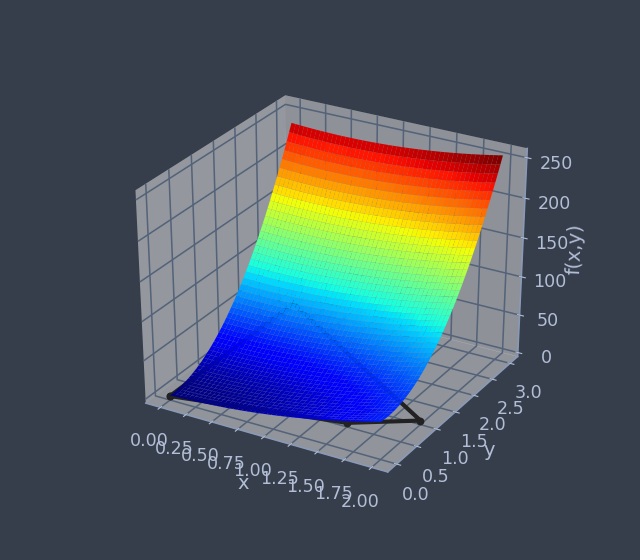

Text(0.5, 0, 'f(x,y)')

In [30]:
xvals = np.array([0., 2, 3/2, 0])
yvals = np.array([0., 1, 1/2, 3])
X,Y = np.meshgrid(np.linspace(xvals.min(), xvals.max(), 50),
                  np.linspace(yvals.min(), yvals.max(), 50))
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(np.hstack((xvals[[0, 2, 1, 3]], xvals[0])),
        np.hstack((yvals[[0, 2, 1, 3]], yvals[0])), "-ko", zs = 0, zdir="z", lw=3)
ax.plot_surface(X,Y, 1. + 3.*X - 2.*Y + 9*X**2 - 4*X*Y + 27*Y**2, cmap = cm.jet)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
ax.set_zlabel(r"f(x,y)", fontsize=14)


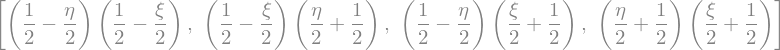

In [32]:
shp

In [33]:
# rearranging the points
xQ = shp @ xvals[[0, 3, 2, 1]]
yQ = shp @ yvals[[0, 3, 2, 1]]

In [34]:
JQ = Matrix([[xQ.diff(xi), xQ.diff(eta)], [yQ.diff(xi), yQ.diff(eta)]])

<IPython.core.display.Javascript object>


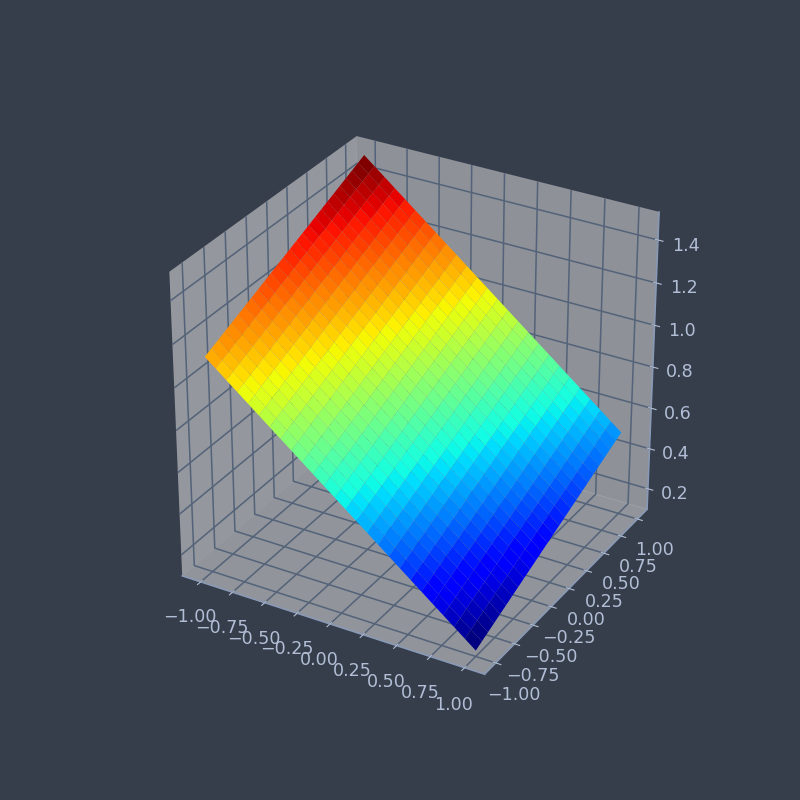

In [35]:
J = simplify(JQ.det())
Jfunc = lambdify((xi,eta), J, "numpy")
xi_vals = np.linspace(-1,1,51)
XI, ETA = np.meshgrid(xi_vals, xi_vals)
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.gca(projection="3d")
ax1.plot_surface(XI, ETA, Jfunc(XI, ETA), cmap = cm.jet)

In [36]:
Aq_exact = integrate((1 + 3*xQ - 2*yQ + 9*xQ**2 - 4*xQ*yQ + 27*yQ**2)*J,
                     (xi, -1, 1), (eta, -1, 1))

In [37]:
from numpy.polynomial.legendre import leggauss

In [38]:
Aq_exact

In [39]:
pts, wg = leggauss(2)

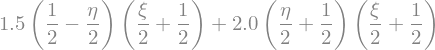

In [45]:
func = simplify(1 + 3*xQ - 2*yQ + 9*xQ**2 - 4*xQ*yQ + 27*yQ**2)*J

In [46]:
func

In [47]:
ptsQ = np.meshgrid(pts, pts)

In [48]:
ptsQ

[array([[-0.57735027,  0.57735027],
        [-0.57735027,  0.57735027]]), array([[-0.57735027, -0.57735027],
        [ 0.57735027,  0.57735027]])]

In [49]:
ptsQ[0]

array([[-0.57735027,  0.57735027],
       [-0.57735027,  0.57735027]])

In [50]:
ptsQ[1]

array([[-0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027]])

In [52]:
fun = lambdify((xi, eta), func, "numpy")

In [57]:
Aq_Gaussian = np.sum(fun(ptsQ[0], ptsQ[1]))

In [58]:
abs(Aq_Gaussian - Aq_exact)